# Data Analysis
## People

In this notebook, we will see how leading personnels (e.g. cast, writer, director, etc.) is related to the success of the film. Additionally we will see if the trend is different for domestic sales vs. worldwide.

In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("talk")

In [371]:
#loading data
df = pd.read_csv('data/profit_data.csv', index_col = 0)
df.head(2)

,popularity,vote_count,id_x,adult,original_language,title,vote_average,overview,MPAA,year,...,actors,directors,producers,editors,writers,primary_genre,secondary_genre,new_genre,worldwide_gross_z,domestic_gross_z
0,31.998,2653,189,False,en,sin city: a dame to kill for,6.3,Some of Sin City's most hard-boiled citizens c...,R,2014,...,"Josh Brolin,Mickey Rourke,Jessica Alba,Joseph ...","Frank Miller,Robert Rodriguez","Mark C. Manuel,Sergei Bespalov,Aaron Kaufman,S...",NaN,NaN,Crime,Thriller,Crime,-0.536238,-0.627326
1,14.736,15131,1771,False,en,captain america: the first avenger,6.9,"During World War II, Steve Rogers is a sickly ...",PG-13,2011,...,"Chris Evans,Samuel L. Jackson,Hugo Weaving,Hay...",Joe Johnston,Kevin Feige,NaN,"Jack Kirby,Christopher Markus,Stephen McFeely,...",Action,Adventure,Action,0.796567,1.199239


In [372]:
df.isnull().sum()

popularity              0
vote_count              0
id_x                    0
adult                   0
original_language       0
title                   0
vote_average            0
overview                0
MPAA                  132
year                    0
month                   0
studio                192
production_budget       0
domestic_gross          0
worldwide_gross         0
tconst                  0
primary_title           0
original_title          0
start_year              0
runtime_minutes         0
genres                  0
avg_rating_imdb         0
num_votes_imdb          0
actors                  7
directors              32
producers             135
editors              1048
writers               170
primary_genre           0
secondary_genre        67
new_genre               0
worldwide_gross_z       0
domestic_gross_z        0
dtype: int64

## Missing Values
Actors, directors, producers, editors, writers names are important in our analyses and cannot be inferred. We can either choose to manually input these data or merge with other data source. But for the timebeing, we will eliminate these rows per section (directors, writers, etc) separately. 

## Additional Data Cleaning
We'll do some additional works for this particular analyses.

In [373]:
# add top 4 main actors
actors = df.actors.str.split(',', expand = True)
df['cast_1'] = actors[0]
df['cast_2'] = actors[1]
df['cast_3'] = actors[2]
df['cast_4'] = actors[3]

In [374]:
# add the main director
directors = df.directors.str.split(',', expand = True)
df['main_director'] = directors[0]

In [375]:
# add the main writer
writers = df.writers.str.split(',', expand = True)
df['main_writer'] = writers[0]

In [376]:
# add popularity/rating z-score
df['popularity_z'] = df.popularity.apply(lambda x: (x-df.popularity.mean())/(df.popularity.std()))
df['rating_z_IMDB'] = df.avg_rating_imdb.apply(lambda x: (x-df.avg_rating_imdb.mean())/(df.avg_rating_imdb.std()))

## Directors

### Prolific Directors

In [377]:
num_films_p_dirs = df.groupby('main_director').title.count().sort_values(ascending = False)

print("""Out of {} directors in our dataset, 
{} is the most prolific director with {} movies since 2010.""".format(len(num_films_p_dirs), num_films_p_dirs.index[0], num_films_p_dirs[0]))


Out of 727 directors in our dataset, 
Steven Spielberg is the most prolific director with 7 movies since 2010.


### Top 20 Grossing Directors (Worldwide)

In [378]:
dirdf = df.copy()[['title', 'worldwide_gross', 'domestic_gross', 'rating_z_IMDB', 'popularity_z', 'production_budget', 'main_director']]

# drop if no director. 
dirdf.dropna(subset = ['main_director'], inplace = True)

In [379]:
# Select top 20 directors with highest worldwide grossing
top20 = dirdf.groupby('main_director')['worldwide_gross', 'domestic_gross', 'production_budget']\
.sum().sort_values(by = 'worldwide_gross', ascending = False)[0:20]

In [380]:
# For these directors, get average IMDB rating and TMDB popularity scores. 
top20_names = top20.index
top20_subdf = dirdf[dirdf.main_director.isin(top20_names)].groupby('main_director')['rating_z_IMDB', 'popularity_z'].mean()
# Merge datasets
top20 = top20.join(top20_subdf)
top20 = top20.reset_index()

<Figure size 720x432 with 0 Axes>

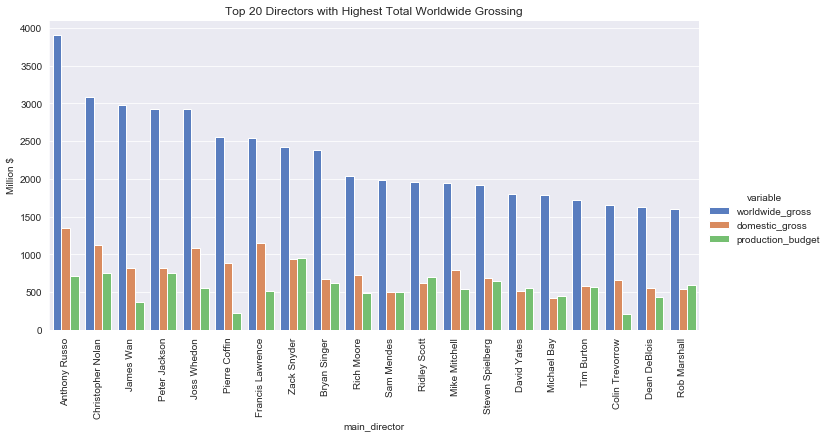

In [381]:
tmp = pd.melt(top20, id_vars=['main_director'], value_vars=['worldwide_gross', 'domestic_gross', 'production_budget'])

fig = plt.figure(figsize = (10,6))
g = sns.catplot(x="main_director", y="value", hue="variable", data=tmp, kind="bar", palette="muted", aspect = 2.)
g.set_xticklabels(rotation=90)
g.set(title = "Top 20 Directors with Highest Total Worldwide Grossing", ylabel = "Million $")
plt.show()


In [382]:
for director in top20.main_director:
    print(f"{director}:    {df[df.main_director == director].original_title.iloc[0]}")
    


Anthony Russo:    Captain America: The Winter Soldier
Christopher Nolan:    Inception
James Wan:    The Conjuring
Peter Jackson:    The Hobbit: An Unexpected Journey
Joss Whedon:    The Avengers
Pierre Coffin:    Despicable Me
Francis Lawrence:    Water for Elephants
Zack Snyder:    Sucker Punch
Bryan Singer:    Jack the Giant Slayer
Rich Moore:    Wreck-It Ralph
Sam Mendes:    Skyfall
Ridley Scott:    Robin Hood
Mike Mitchell:    Shrek Forever After
Steven Spielberg:    The Adventures of Tintin
David Yates:    The Legend of Tarzan
Michael Bay:    Transformers: Age of Extinction
Tim Burton:    Alice in Wonderland
Colin Trevorrow:    Safety Not Guaranteed
Dean DeBlois:    How to Train Your Dragon
Rob Marshall:    Pirates of the Caribbean: On Stranger Tides


Anthony Russo (Captain America: The Winter Soldier) has unmatched success globally.  
While James Wan (The Conjuring) had a huge success with relatively small budget.  
Pierre Coffin follws closely after with even lower production budget.

### Do their IMDB rating and TMDB popularity measure up?

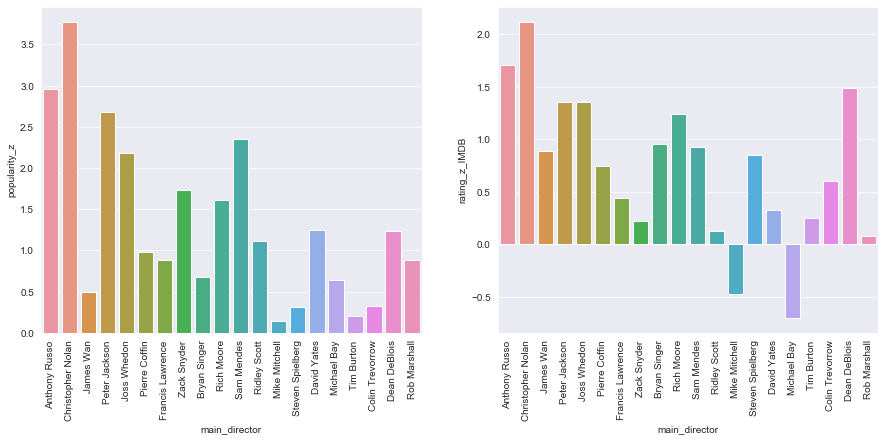

In [383]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(top20.main_director, top20.popularity_z, ax = ax1)
sns.barplot(top20.main_director, top20.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20.main_director, rotation=90)
ax2.set_xticklabels(labels = top20.main_director, rotation=90)


plt.show()

All of these top 20 directors' movies are above average.  
But Anthony Russo, Christopher Nolan, Peter Jackson and Sam Mendes has movies on average are above 95th percentile popularity.  
James Wan, despite his success, remains with just average popularity. (And this aligns with the fact that horror movies are never quite 'popular'.) 

These directors yielded highest cumulative grossing worldwide.  
But some might have been just more productive in the past decade.  
Let's look at the directors with highest average grossing per movie.

In [384]:
# Select top 20 directors with highest worldwide grossing
top20_mean = dirdf.groupby('main_director')['worldwide_gross', 'domestic_gross', 'production_budget', 'rating_z_IMDB', 'popularity_z']\
.mean().sort_values(by = 'worldwide_gross', ascending = False)[0:20]

<Figure size 1440x720 with 0 Axes>

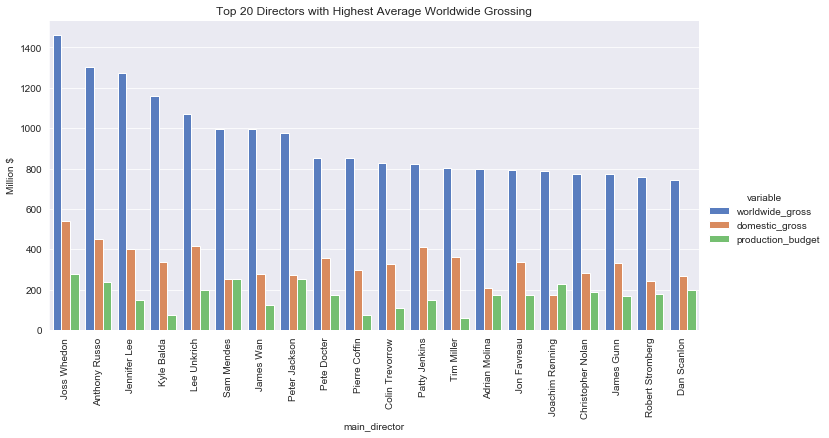

In [385]:
top20_mean = top20_mean.reset_index()
tmp = pd.melt(top20_mean, id_vars=['main_director'], value_vars=['worldwide_gross', 'domestic_gross', 'production_budget'])

fig = plt.figure(figsize = (20,10))
g = sns.catplot(x="main_director", y="value", hue="variable", data=tmp, kind="bar", palette="muted", aspect = 2)
g.set_xticklabels(rotation=90)
g.set(title = "Top 20 Directors with Highest Average Worldwide Grossing", ylabel = "Million $")
plt.show()


In [386]:
for director in top20_mean.main_director:
    print(f"{director}:    {df[df.main_director == director].original_title.iloc[0]}")
    


Joss Whedon:    The Avengers
Anthony Russo:    Captain America: The Winter Soldier
Jennifer Lee:    Frozen
Kyle Balda:    Minions
Lee Unkrich:    Toy Story 3
Sam Mendes:    Skyfall
James Wan:    The Conjuring
Peter Jackson:    The Hobbit: An Unexpected Journey
Pete Docter:    Inside Out
Pierre Coffin:    Despicable Me
Colin Trevorrow:    Safety Not Guaranteed
Patty Jenkins:    Wonder Woman
Tim Miller:    Deadpool
Adrian Molina:    Coco
Jon Favreau:    Iron Man 2
Joachim Rønning:    Pirates of the Caribbean: Dead Men Tell No Tales
Christopher Nolan:    Inception
James Gunn:    Guardians of the Galaxy
Robert Stromberg:    Maleficent
Dan Scanlon:    Monsters University


When looking at the average revenue per movies, Joss Whedon with the Avengers made the mode success worldwide.  
Kyle Balda and Jennifer Lee are on average bringing in high revenues with relatively low budget.  



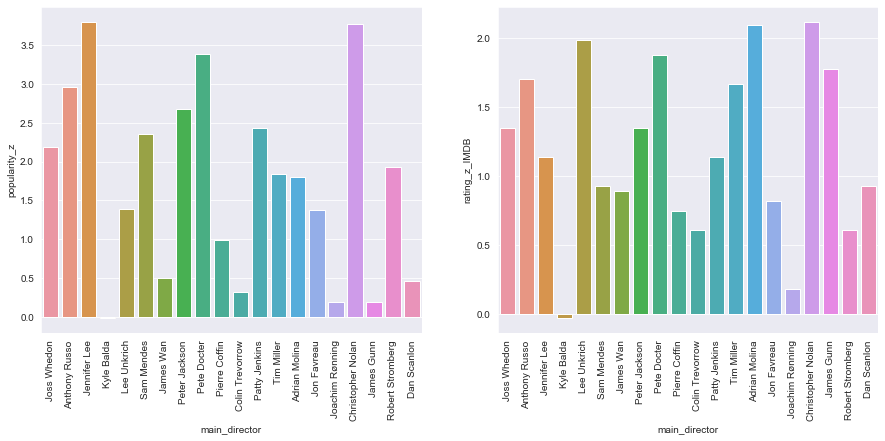

In [387]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(top20_mean.main_director, top20_mean.popularity_z, ax = ax1)
sns.barplot(top20_mean.main_director, top20_mean.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20_mean.main_director, rotation=90)
ax2.set_xticklabels(labels = top20_mean.main_director, rotation=90)


plt.show()

But movies by Kyle Balda is just about average.  
(Please note that these are z-scored across the boards, so 0 means they are around the average.)  
Jennifer Lee seems to also generate unmatched popularity. More the reason to look into adventure animations. 


### Who's the most popular?
Based on average popularity and the ratings

In [388]:
tmp = dirdf.groupby('main_director')['rating_z_IMDB', 'popularity_z'].mean()
tmp[tmp.rating_z_IMDB > 1].sort_values(by = 'popularity_z', ascending = False)[0:15]
# Top 15 popular directors with high average IMDB ratings

,rating_z_IMDB,popularity_z
main_director,,
Jennifer Lee,1.138983,3.801929
Christopher Nolan,2.121317,3.767455
Don Hall,1.457578,3.528442
Pete Docter,1.882371,3.386656
Anthony Russo,1.705374,2.954860
Peter Jackson,1.351380,2.677161
Patty Jenkins,1.138983,2.430362
Joss Whedon,1.351380,2.187553
Tim Miller,1.669974,1.834546


As seen above, Jennifer Lee has unmatched popularity with Frozen. Followed by Christopher Nolan, whose popularity seems to shine overseas.

## Writers

In [389]:
num_films_p_writers = df.groupby('main_writer').title.count().sort_values(ascending = False)

print("""Out of {} writers in our dataset, 
{} is the most prolific writer with {} movies since 2010.""".format(len(num_films_p_writers), num_films_p_writers.index[0], num_films_p_writers[0]))


Out of 753 writers in our dataset, 
Jack Kirby is the most prolific writer with 11 movies since 2010.


### Top 10 Highest Grossing Writers

In [390]:
writerdf = df[['title', 'worldwide_gross', 'domestic_gross', 'rating_z_IMDB', 'popularity_z', 'production_budget', 'main_writer']]


In [391]:
# Select top 20 writers with highest worldwide grossing
top20 = writerdf.groupby('main_writer')['worldwide_gross', 'domestic_gross', 'production_budget']\
.sum().sort_values(by = 'worldwide_gross', ascending = False)[0:20]

In [392]:
# For these directors, get average IMDB rating and TMDB popularity scores. 
top20_names = top20.index
top20_subdf = writerdf[writerdf.main_writer.isin(top20_names)].groupby('main_writer')['rating_z_IMDB', 'popularity_z'].mean()
# Merge datasets
top20 = top20.join(top20_subdf)
top20 = top20.reset_index()

<Figure size 720x432 with 0 Axes>

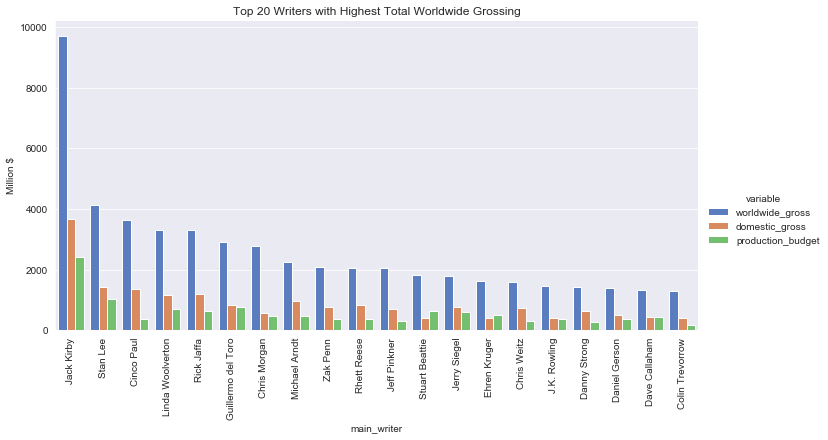

In [393]:
tmp = pd.melt(top20, id_vars=['main_writer'], value_vars=['worldwide_gross', 'domestic_gross', 'production_budget'])

fig = plt.figure(figsize = (10,6))
g = sns.catplot(x="main_writer", y="value", hue="variable", data=tmp, kind="bar", palette="muted", aspect = 2.)
g.set_xticklabels(rotation=90)
g.set(title = "Top 20 Writers with Highest Total Worldwide Grossing", ylabel = "Million $")
plt.show()


In [394]:
for writer in top20.main_writer:
    print(f"{writer}:    {df[df.main_writer == writer].original_title.iloc[0]}")
    


Jack Kirby:    Captain America: The First Avenger
Stan Lee:    The Amazing Spider-Man
Cinco Paul:    Despicable Me
Linda Woolverton:    Alice in Wonderland
Rick Jaffa:    Rise of the Planet of the Apes
Guillermo del Toro:    The Hobbit: An Unexpected Journey
Chris Morgan:    The Vatican Tapes
Michael Arndt:    Toy Story 3
Zak Penn:    The Avengers
Rhett Reese:    G.I. Joe: Retaliation
Jeff Pinkner:    The 5th Wave
Stuart Beattie:    Pirates of the Caribbean: On Stranger Tides
Jerry Siegel:    Man of Steel
Ehren Kruger:    Transformers: Age of Extinction
Chris Weitz:    Cinderella
J.K. Rowling:    Fantastic Beasts and Where to Find Them
Danny Strong:    The Hunger Games: Mockingjay - Part 1
Daniel Gerson:    Monsters University
Dave Callaham:    The Expendables
Colin Trevorrow:    Jurassic World: Fallen Kingdom


Here we clearly sees the dominance of cartoon based superhero movies.  

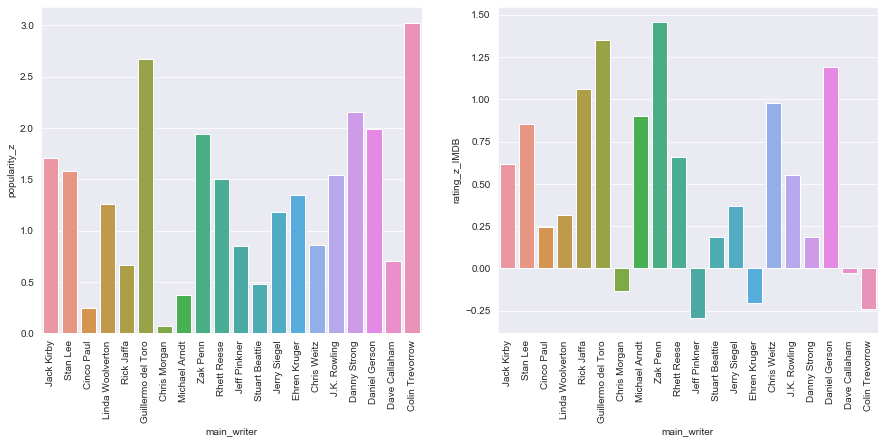

In [395]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(top20.main_writer, top20.popularity_z, ax = ax1)
sns.barplot(top20.main_writer, top20.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20.main_writer, rotation=90)
ax2.set_xticklabels(labels = top20.main_writer, rotation=90)

plt.show()

### Who's the most popular?

In [396]:
tmp = writerdf.groupby('main_writer')['rating_z_IMDB', 'popularity_z'].mean()
tmp[tmp.rating_z_IMDB > 1].sort_values(by = 'popularity_z', ascending = False)[0:15]

,rating_z_IMDB,popularity_z
main_writer,,
Jonathan Nolan,2.307164,6.411904
John August,1.032785,4.111865
Hans Christian Andersen,1.138983,3.801929
James Cameron,1.138983,3.466965
Simon Rich,1.882371,3.386656
Guillermo del Toro,1.351380,2.677161
Graham Moore,1.669974,2.566438
Phil Johnston,1.669974,2.358194
Drew Goddard,1.669974,2.259661


## Casts
Here we are interested in casts who have gained relatively more success worldwide vs. domestic.  
So we will use normalized measure of gross revenue.

In [423]:
casts_rev = df[['worldwide_gross_z', 'domestic_gross_z', 'cast_1', 'cast_2']]
casts_rev_m = pd.melt(casts_rev, id_vars = ['worldwide_gross_z', 'domestic_gross_z'], value_vars = ['cast_1', 'cast_2'])

In [424]:
casts_rev_m = casts_rev_m.groupby('value')[['worldwide_gross_z', 'domestic_gross_z']].mean().reset_index()

In [425]:
casts_rev_m.sort_values('worldwide_gross_z', ascending = False, inplace = True)

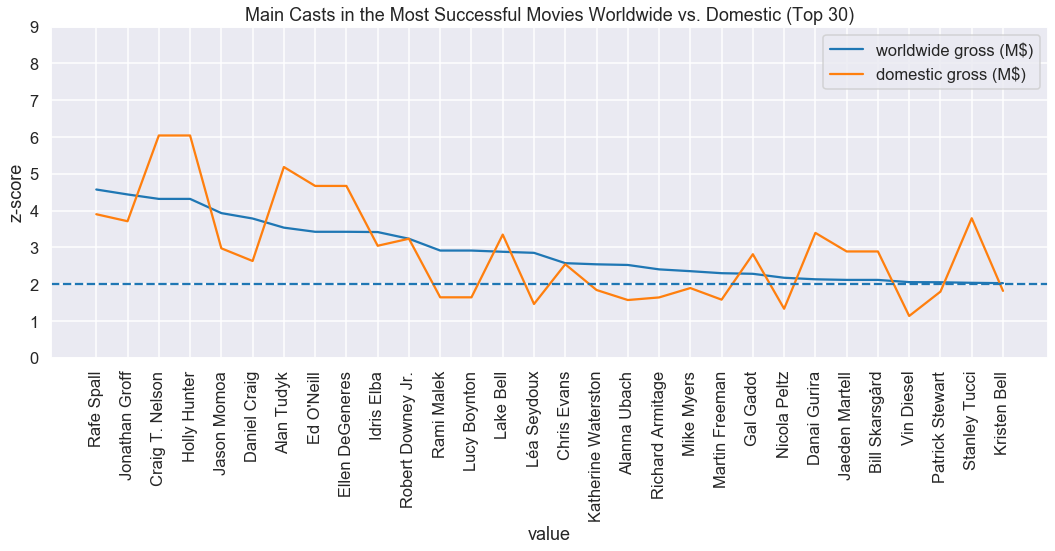

In [426]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(111)

sns.lineplot(x = 'value', y = 'worldwide_gross_z', 
             label = 'worldwide gross (M$)', data = casts_rev_m[0:30], sort = False, ax = ax1)
sns.lineplot(x = 'value', y = 'domestic_gross_z', 
             label = 'domestic gross (M$)', data = casts_rev_m[0:30], sort = False, ax = ax1)

#label = 'domestic gross',
ax1.set_xticklabels(labels = casts_rev_m[0:30].value, rotation=90)
ax1.axhline(2, ls='--')
ax1.set_ylim([0,9])
plt.ylabel("z-score")
plt.title("Main Casts in the Most Successful Movies Worldwide vs. Domestic (Top 30)")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("PNG/Top30_Successful_Casts.png")

In [427]:
for cast in casts_rev_m.value[0:30]:
    print(f"{cast}:    {df[(df.cast_1 == cast) | (df.cast_2 == cast)].original_title.iloc[0]}")

Rafe Spall:    Jurassic World: Fallen Kingdom
Jonathan Groff:    Frozen
Craig T. Nelson:    Incredibles 2
Holly Hunter:    Incredibles 2
Jason Momoa:    Aquaman
Daniel Craig:    Skyfall
Alan Tudyk:    Rogue One
Ed O'Neill:    Finding Dory
Ellen DeGeneres:    Finding Dory
Idris Elba:    Zootopia
Robert Downey Jr.:    Iron Man 2
Rami Malek:    Bohemian Rhapsody
Lucy Boynton:    Bohemian Rhapsody
Lake Bell:    The Secret Life of Pets
Léa Seydoux:    Spectre
Chris Evans:    Captain America: The First Avenger
Katherine Waterston:    Fantastic Beasts and Where to Find Them
Alanna Ubach:    Coco
Richard Armitage:    The Hobbit: An Unexpected Journey
Mike Myers:    Shrek Forever After
Martin Freeman:    The Hobbit: An Unexpected Journey
Gal Gadot:    Justice League
Nicola Peltz:    The Last Airbender
Danai Gurira:    Black Panther
Jaeden Martell:    It
Bill Skarsgård:    It
Vin Diesel:    xXx: Return of Xander Cage
Patrick Stewart:    X-Men: Days of Future Past
Stanley Tucci:    The Hunger Gam

It seems like top 30 casts are all well above 95th percentile in either market.  
But from seeing the success of voice casts in global market relative to domestic market, we can presume animation for children may be relatively more successful than other genres.

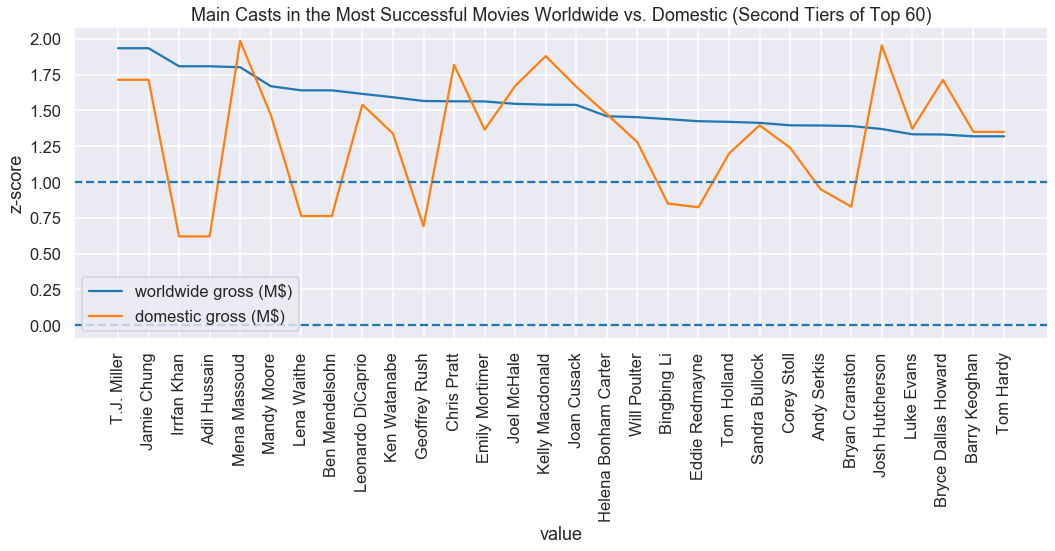

In [428]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(111)

sns.lineplot(x = 'value', y = 'worldwide_gross_z', 
             label = 'worldwide gross (M$)', data = casts_rev_m[30:60], sort = False, ax = ax1)
sns.lineplot(x = 'value', y = 'domestic_gross_z', 
             label = 'domestic gross (M$)', data = casts_rev_m[30:60], sort = False, ax = ax1)

#label = 'domestic gross',
ax1.set_xticklabels(labels = casts_rev_m[30:60].value, rotation=90)
ax1.axhline(1, ls='--')
ax1.axhline(0, ls='--')

plt.ylabel("z-score")
plt.title("Main Casts in the Most Successful Movies Worldwide vs. Domestic (Second Tiers of Top 60)")
plt.legend()
plt.tight_layout()

plt.show()
fig.savefig("PNG/Top30-60_Successful_Casts.png")

In [429]:
for cast in casts_rev_m.value[30:60]:
    print(f"{cast}:    {df[(df.cast_1 == cast) | (df.cast_2 == cast)].original_title.iloc[0]}")

T.J. Miller:    Big Hero 6
Jamie Chung:    Big Hero 6
Irrfan Khan:    Life of Pi
Adil Hussain:    Life of Pi
Mena Massoud:    Aladdin
Mandy Moore:    Tangled
Lena Waithe:    Ready Player One
Ben Mendelsohn:    Ready Player One
Leonardo DiCaprio:    Inception
Ken Watanabe:    Inception
Geoffrey Rush:    Pirates of the Caribbean: On Stranger Tides
Chris Pratt:    Zero Dark Thirty
Emily Mortimer:    Cars 2
Joel McHale:    Ted
Kelly Macdonald:    Brave
Joan Cusack:    Toy Story 3
Helena Bonham Carter:    Cinderella
Will Poulter:    The Revenant
Bingbing Li:    The Meg
Eddie Redmayne:    Fantastic Beasts and Where to Find Them
Tom Holland:    Lo imposible
Sandra Bullock:    Our Brand Is Crisis
Corey Stoll:    Ant-Man
Andy Serkis:    The Adventures of Tintin
Bryan Cranston:    Kung Fu Panda 3
Josh Hutcherson:    Red Dawn
Luke Evans:    Dracula Untold
Bryce Dallas Howard:    50/50
Barry Keoghan:    Dunkirk
Tom Hardy:    Dunkirk


It seems like movies like Life of Pi, Aladdin, and Ready Player One had shown remarkably more success globally while their performance was about average for domestic crowd.  
Diversity of represented crowd and the gaming as a topic might be appealing to the global market.  

Top 10 Actors in movies that were more popular worldwide but not in domestic

In [410]:
casts_rev_m['rev_z_diff'] = casts_rev_m['worldwide_gross_z'] - casts_rev_m['domestic_gross_z']

In [415]:
casts_high_revzdiff = casts_rev_m.sort_values(by = 'rev_z_diff', ascending = False).head(20)
casts_high_revzdiff

,value,worldwide_gross_z,domestic_gross_z,rev_z_diff
655,Léa Seydoux,2.853018,1.461859,1.391159
647,Lucy Boynton,2.915109,1.643854,1.271256
826,Rami Malek,2.915109,1.643854,1.271256
396,Irrfan Khan,1.807886,0.619950,1.187935
12,Adil Hussain,1.807886,0.619950,1.187935
237,Daniel Craig,3.785844,2.631313,1.154531
1,Aamir Khan,0.489866,-0.642688,1.132555
888,Sakshi Tanwar,0.489866,-0.642688,1.132555
278,Donnie Yen,0.693391,-0.278138,0.971528
441,Jason Momoa,3.932730,2.975567,0.957163


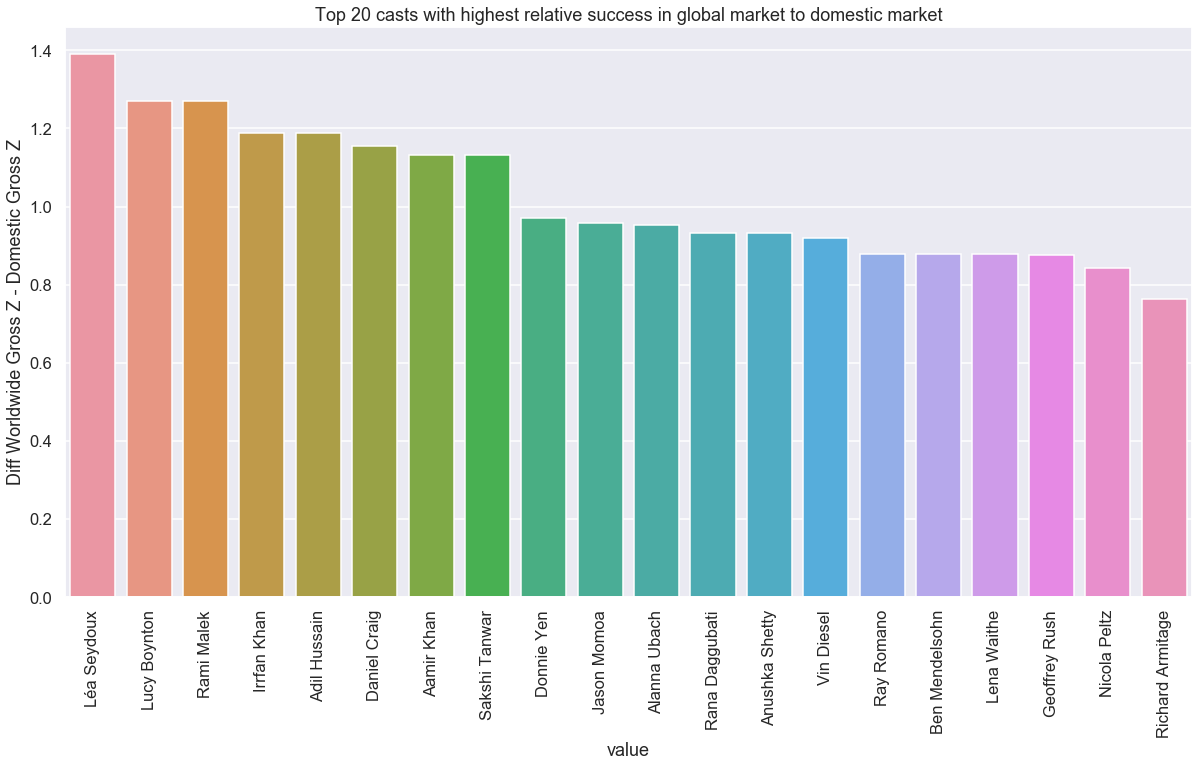

In [422]:
plt.figure(figsize = (17, 11))

ax1 = sns.barplot(casts_high_revzdiff.value, casts_high_revzdiff.rev_z_diff)
ax1.set_xticklabels(labels = casts_high_revzdiff.value, rotation=90)
plt.title("Top 20 casts with highest relative success in global market to domestic market")
plt.ylabel("Diff Worldwide Gross Z - Domestic Gross Z")
plt.tight_layout()

plt.show()
ax1.figure.savefig("PNG/Top20_Relative_WorldwideStars.png")

In [417]:
for cast in casts_high_revzdiff.value:
    print(f"{cast}:    {df[(df.cast_1 == cast) | (df.cast_2 == cast)].original_title.iloc[0]}")

Léa Seydoux:    Spectre
Lucy Boynton:    Bohemian Rhapsody
Rami Malek:    Bohemian Rhapsody
Irrfan Khan:    Life of Pi
Adil Hussain:    Life of Pi
Daniel Craig:    Skyfall
Aamir Khan:    Dangal
Sakshi Tanwar:    Dangal
Donnie Yen:    xXx: Return of Xander Cage
Jason Momoa:    Aquaman
Alanna Ubach:    Coco
Rana Daggubati:    Baahubali 2: The Conclusion
Anushka Shetty:    Baahubali 2: The Conclusion
Vin Diesel:    xXx: Return of Xander Cage
Ray Romano:    Ice Age: Continental Drift
Ben Mendelsohn:    Ready Player One
Lena Waithe:    Ready Player One
Geoffrey Rush:    Pirates of the Caribbean: On Stranger Tides
Nicola Peltz:    The Last Airbender
Richard Armitage:    The Hobbit: An Unexpected Journey


Above are the casts with highest relative success in global market compared to the domestic market.  
It brings bollywood as an important market to target. 
007, music, diversity, gaming, bollywood might be some of the important keywords to look at.
